Просмотр фильмов на оригинальном языке это популярный и действенный метод прокачаться при изучении иностранных языков. Важно выбрать фильм, который подходит студенту по уровню сложности, так, чтобы студент понимал 50 - 70% диалогов. Чтобы выполнить это условие, преподаватель должен посмотреть фильм и решить, какому уровню он соответствует. Однако это требует больших временных затрат.

Задача: 

- Разработать ML решение для автоматического определения уровня сложности англоязычных фильмов. Обучить языковую модель и разработать для неё веб-интерфейс (Streamlit).

In [1]:
! pip install -q spacy


In [2]:
! pip install pysrt

In [3]:
import pandas as pd
import os
import re
import numpy as np
import pysrt
import spacy
import en_core_web_sm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pickle
from sklearn.pipeline import Pipeline


2023-05-12 22:07:09.513134: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-12 22:07:09.513196: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-12 22:07:11.718076: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-12 22:07:11.718109: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-12 22:07:11.718127: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (HP-sergifranb2023): /proc/driver/nvidia/version does not exist
[nltk_data] Downloading package stopwords to
[nltk_data]   

Этап 1. После импорта необходимых библиотек загрузим данные в датафрейм с помощью библиотеки pysrt, предназначенной для работы с субтитрами.

In [4]:
def fetch_subs(path):
    data = {}
    films = os.listdir(path=path)
    for i in range(len(films)):
        subs = pysrt.open(path + films[i], encoding='iso-8859-1')
        subs_text = []
        for sub in subs:
            subs_text.append(sub.text_without_tags.split('\n'))
        data[films[i]] = subs_text
    data = pd.DataFrame({'Movie': films, 'Subtitles': data.values()})
    return data


df1 = fetch_subs('./Subtitles/')

df1

,Movie,Subtitles
0,The Walking Dead-S01E06-TS-19.English.srt,"[[- ( people yelling ), - ( radio chatter )], ..."
1,The.Sound.of.Music.1965.WEBRip.iTunes.srt,"[[The hills are alive], [With the sound of mus..."
2,Ratatouille(2007).srt,"[[Downloaded From www.AllSubs.org], [Although ..."
3,Suits.Episode 2- Compensation.srt,"[[- I'm leaving you, Harvey., - You can't just..."
4,"Crown, The S01E01 - Wolferton Splash.en.SDH.srt","[[[coughing]], [[coughing continues]], [[spits..."
...,...,...
275,Shrek(2001).srt,"[[anoXmous, https://thepiratebay.se/user/Zen_B..."
276,Suits.Episode 9- Uninvited Guests.srt,"[[- Pursuant to section 28b, of the bylaws,], ..."
277,Gogo_Loves_English.srt,"[[[Music]], [so], [[Music]], [wow], [[Music]],..."
278,Suits.Episode 4- No Puedo Hacerlo.srt,"[[You took this case, without running it by me..."


Удалим в столбце Movie последние 4 символа (.srt), чтобы в дальнейшем по названию фильма присоединить датафрейм с указанием фильмов и их уровней сложности.

In [5]:
df1['Movie'] = [i[:-4] for i in df1['Movie']]

In [6]:
df1.loc[1, 'Subtitles']

[['The hills are alive'],
 ['With the sound of music'],
 ['With songs they have sung'],
 ['For a thousand years'],
 ['The hills fill my heart'],
 ['With the sound of music'],
 ['My heart wants to sing', 'Every song it hears'],
 ['My heart wants to beat like the wings', 'Of the birds that rise'],
 ['From the lake to the trees'],
 ['My heart wants to sigh', 'Like a chime that flies'],
 ['From a church on a breeze'],
 ['To laugh like a brook', 'When it trips and falls'],
 ['Over stones on its way'],
 ['To sing through the night'],
 ['Like a lark who is learning to pray'],
 ['I go to the hills'],
 ['When my heart is lonely'],
 ['I know I will hear'],
 ["What I've heard before"],
 ['My heart will be blessed'],
 ['With the sound of music'],
 ["And I'll sing"],
 ['Once more'],
 ['Hallelujah, hallelujah'],
 ['Hallelujah, hallelujah'],
 ['-Reverend Mother.', '-Sister Bernice.'],
 ['-I simply cannot find her.', '-Maria?'],
 ["She's missing again."],
 ["We should've put a cowbell", 'around her ne

Подгружаем датафрейм с указанием фильмов и их уровней сложности. Затем соединяем два датафрейма, убрав неинформативную колонку id.


In [7]:
df2 = pd.read_excel('./Subtitles/movies_labels.xlsx')

In [8]:
df2

,id,Movie,Level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2/A2+
...,...,...,...
236,236,Matilda(2022),C1
237,237,Bullet train,B1
238,238,Thor: love and thunder,B2
239,239,Lightyear,B2


In [9]:
df = df2.merge(df1, on ='Movie')
df = df.drop(['id'], axis=1)
df

,Movie,Level,Subtitles
0,10_Cloverfield_lane(2016),B1,"[[Fixed & Synced by bozxphd. Enjoy The Flick],..."
1,10_things_I_hate_about_you(1999),B1,"[[Hey!], [I'll be right with you.], [So, Camer..."
2,A_knights_tale(2001),B2,"[[Resync: Xenzai[NEF], RETAIL], [Should we hel..."
3,A_star_is_born(2018),B2,"[[- Synced and corrected by mrcjnthn -], [Ge..."
4,Aladdin(1992),A2/A2+,"[[Oh, I come from a land, From a faraway place..."
...,...,...,...
228,Suits.S03E06.720p.HDTV.x264-mSD,C1,"[[I lost Ava her company.], [I assume my deal,..."
229,Suits.S03E07.HDTV.x264-mSD,C1,"[[Previously on, Suits...], [It's going up, on..."
230,Suits.S03E08.480p.HDTV.x264-mSD,C1,"[[I get Ava Hessington acquitted,], [Darby bac..."
231,Suits.S03E09.480p.HDTV.x264-mSD,C1,"[[Previously on, Suits...], [I'm bonding, with..."


В таблице уровни некоторых фильмов указаны через слэш или запятую. Из двух или трёх предлагаемых уровней оставим самый высокий, чтобы пользователь не решил, что фильм всё-таки слишком сложный для него. 

In [10]:
df['Level'].unique()

df['Level']= df['Level'].replace('A2/A2+','A2+')
df['Level']= df['Level'].replace('A2/A2+, B1','B1')
df['Level']= df['Level'].replace('B1, B2','B2')

df['Level'].unique()

array(['B1', 'B2', 'A2+', 'C1', 'A2'], dtype=object)

Этап 2. Начинаем переходить к ML. Выделим в таблице два ключевых столбца: текст субтитров, который подвергнем предобработке, и непосредственно уровень сложности (целевой столбец, y).

In [11]:
X,y = df['Subtitles'], df['Level']

Создаем алгоритм предобработки субтитров с помощью регулярных выражений (библиотека re) и библиотеки spacy.

In [12]:
nlp = spacy.load("en_core_web_sm")

In [13]:
def preprocess(text):
    # удаление символов
    document = re.sub(r'\W', ' ', str(text))
    # удаление одиноко стоящих слов
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    # приведение к нижнему регистру 
    document = document.lower()
    # токенизация
    #document = nltk.word_tokenize(document,language = "english")
    # лемматизация
    spacy_results = nlp(document)
    document = ' '.join([token.lemma_ for token in spacy_results])
    return document

Применяем функцию предобработки к текстам субтитров. Небыстро...:)

In [14]:
X = X.apply(preprocess)

In [15]:
print(X[1])

    hey ll be right with you        so   cameron   here you go        nine school in 1 0 year      my   my   army brat         yeah   my dad be         that enough m sure you win find padua     any different than your old school        same little ass wipe shit for brain     everywhere        excuse I   do you just say        be in the right office        not anymore   you re not ve get     deviant to see and novel to finish        now   scoot   scoot        okay        thank   thank lot        patrick verona see we re make     our visit weekly ritual        only so we can have these moment     together   should hit the light        oh   very clever   kangaroo boy        say here you expose yourself     in the cafeteria be joke with the lunch lady      it be bratwurst        bratwurst        aren we the optimist        next time   keep it in your pouch   okay        scoot        hello   michael eckman m suppose to show you around        oh   hi   thank god   you know          normally 

Теперь переводим очищенный текст субтитров в векторный формат с помощью функций CountVectorizer & TfidfTransformer.

In [16]:
vectorizer = CountVectorizer(max_features=4000, stop_words=stopwords.words('english'))
vect = vectorizer.fit(X)
X = vect.transform(X).toarray()

In [17]:

tfidfconverter = TfidfTransformer()
tfidf = tfidfconverter.fit(X)
X = tfidf.transform(X).toarray()


Складываем обученные векторайзер и трансформер в пайплайн, чтобы позже прикрутить его в стримлит для обработки подаваемых пользователями новых субтитров.

In [18]:
pipeline = Pipeline([("vectorizer", vect),("tfidf", tfidf)])

In [19]:
with open("./app/sub_pipe.pcl", "wb") as fid:
    pickle.dump(pipeline,fid)


Предобработка завершена. Изучаем целевой признак.

<AxesSubplot:>

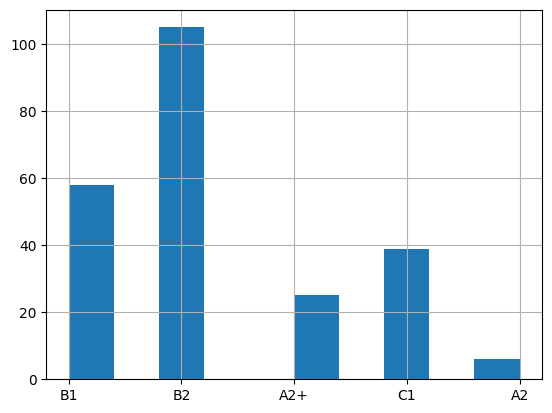

In [20]:
y.hist()

Этап 3. Проводим разбиение на тренировочную и тестовую выборки. Тестовая составит 30% от датафрейма.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 76767)

In [22]:
print(f'train:{X.shape}')
print(f'train:{X_train.shape}')
print(f'train:{X_test.shape}')

train:(233, 4000)
train:(163, 4000)
train:(70, 4000)


Создаем и обучаем модель catboost.

In [23]:
train_pool = Pool(X_train, 
                  y_train)

test_pool = Pool(X_test, y_test) 

model = CatBoostClassifier(verbose=False)
#train the model
model.fit(train_pool) 


In [24]:
predict_train = model.predict(X_train)
print(accuracy_score(y_train, predict_train))

1.0


Далее - тестирование модели.

In [27]:
predict_test = model.predict(test_pool)
accuracy_score(predict_test, y_test)


0.5714285714285714

Этап 4. Создаем фиктивную модель, чтобы сравнить результат ее работы с работой нашей модели.

In [29]:
classes = y.value_counts()
classes

B2     105
B1      58
C1      39
A2+     25
A2       6
Name: Level, dtype: int64

In [30]:
classes.max() /  classes.sum()

0.45064377682403434

Фиктивная модель правильно предсказывает уровень фильма в 45% случаев. У нашей модели accuracy выше 57%.

Confusion matrix показывает, какое количество фильмов какого уровня попадает мимо реального уровня сложности.

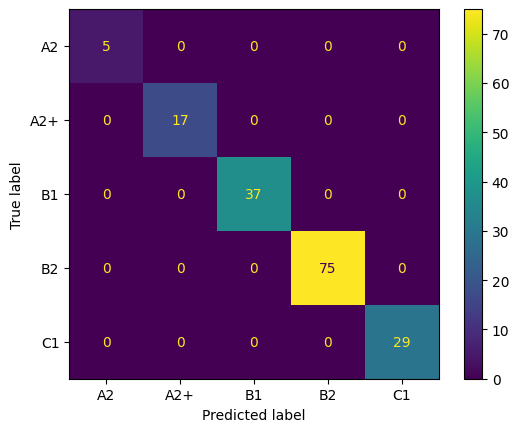

In [31]:
cm = confusion_matrix(y_train, predict_train, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=model.classes_)
disp.plot()


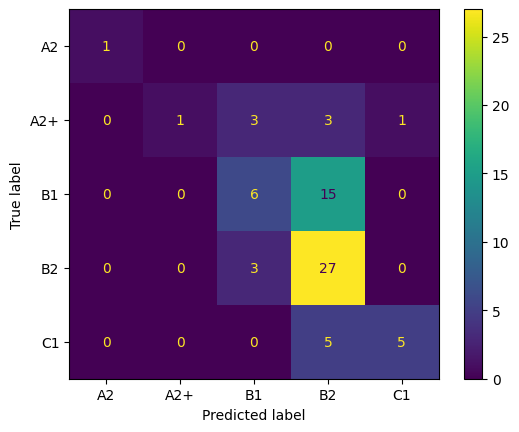

In [32]:
cm = confusion_matrix(y_test, predict_test, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=model.classes_)
disp.plot()

Сохраняем обученную модель.

In [34]:
with open("./app/sub_model.pcl", "wb") as fid:
    pickle.dump(model,fid)

